# 修改自王基栋代码，20251024，V2

# <font color=red>对V1的修改主要是采纳了二分图的思想，从数据点向控制点传递信息，从控制点也尝试反向传递信息。</font>
# 图卷积可以采用现在的，也可以采用nn.module自己写，也可以采用torch_geometric自带的GCN

# 主要修改的地方：1、GCN层：ControlUpdateLayer被替换为GCN层；2、整合层：BSplineGNN

# 模型输入为规范化之后的数据点，输出为控制顶点（未反规范化）
# 因此，对模型的使用必须是：<font color=red>1、数据数据必须通过PointCloudDataset（其中包含数据点规范化、采样等操作），2、控制顶点预测必须通过apply_trained_model函数（其中包括控制顶点饭规范化操作）3、要确保规范化和反规范化函数的匹配</font>

# 原模型的图卷积层用的是torchgeometric，这里我们可以就用gcn或自己写的nn module来实现

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader


# ================== 改进的GNN模型 =================
class NGCFLayer(nn.Module):
    '''
    直接抄自DeepSeek（二分图学习.ipynb）
    将其整合到ControlUpdateLayer即可
    '''
    def __init__(self, in_dim, out_dim):
        super(NGCFLayer,self).__init__()
        self.W1 = nn.Linear(in_dim, out_dim)
        self.W2 = nn.Linear(in_dim, out_dim)
    
    def forward(self, point_residual_feature_emb, control_point_delta_feature_emb, adj):
        # 消息传递
        # adj应该是规范化的邻接矩阵，带不带自循环？带：代表自身feature也参与更新；不带：反之。最终：不带。原因：方便
        # adj使用稀疏矩阵是合理的
        # adj的维度应该是([point_residual_feature_emb]) × ([control_point_delta_feature_emb]) ，不统一编号
        '''
        useremb额itememb其实分别代表point_residual_feature 和 control_point_delta_feature
        '''
        prf_msg = torch.spmm(adj, control_point_delta_feature_emb)  # 从control point delta feature 到 point residual feature
        cpd_msg = torch.spmm(adj.t(), point_residual_feature_emb)  # vice versa
        
        # 嵌入更新
        new_prf_emb = F.leaky_relu(self.W1(point_residual_feature_emb) + self.W2(prf_msg))
        new_cpd_emb = F.leaky_relu(self.W1(control_point_delta_feature_emb) + self.W2(cpd_msg))
        
        return new_prf_emb, new_cpd_emb
    
class LightGCNLayer(nn.Module):
    '''
    据说更有效
    '''
    def __init__(self):
        super(LightGCNLayer,self).__init__()
        
    def forward(self, user_emb, item_emb, adj):
        # 简单的消息传递，无参数
        new_user_emb = torch.spmm(adj, item_emb)  # 归一化在adj中处理
        new_item_emb = torch.spmm(adj.t(), user_emb)
        return new_user_emb, new_item_emb
    

# class ControlUpdateLayer(MessagePassing):
#     """基于基函数加权的残差传播层 """
#     '''
#     传播方向：从数据点向控制顶点传递
#     '''
#     '''
#     图神经网络的parameter在哪里定义的？
#     难道是gru中才有吗？
#     通过在forward中奖gru注释掉发现，BSplineGNN中的ctrlfeat就是相同的，从而可知：本层的可训练参数在gru中
#     '''

#     def __init__(self, hidden_dim):
#         '''
#         通过后面调用过程看到，hiddendim=256
#         这个hiddendim必须和BsplineGNN的hidendim一样，否则程序编译就有问题了。
#         '''
#         super().__init__(aggr='add', flow='source_to_target')
#         self.hidden_dim = hidden_dim
#         self.gru = nn.GRUCell(hidden_dim, hidden_dim) #???
#         self.attn = nn.Sequential( # 如果后面的message中没有用到，则此attn其实是无用的。后面确实没用到，因为据论文中说，不用注意力机制其实效果更好，所以王基栋将其注释掉了。
#             nn.Linear(hidden_dim + 1, 1),  # x_j||basis_weight
#             nn.LeakyReLU(0.2)
#         )

#     def forward(self, point_residual_feat, edge_index, edge_attr, num_src_nodes, num_dst_nodes): # 
#         '''
#         基本上这个是另一个需要改的函数。都是forward函数需要改而已。
#         从后续可以看到，num_src_nodes是数据点个数，num_dst_nodes是控制顶点个数
#         :param point_residual_feat:是通过计算得到的每个node的feature，可以是原始的每个node的坐标，也可以是经过一些计算之后的feature向量。反正只要是合理的图结构即可.注意，通过print shape和查看代码，pointfeat是数据点的残差的feature，其存储的是数据点与B样条曲线之间逐点  !差异向量! 通过mlp之后的特征向量,feature 的维度是256
#         :param edge_attr:是每个数据点与其对应控制顶点之间的基函数系数，预先计算好
#         param point_feat: 数据点与B样条曲线之间差异（numdata × 2）经过mlp之后的feature（numdata × hiddendim）。例：131 × 256。131是数据点个数，256是设定的feature的维度。
#         :param edge_index:  例：2 × 524
#         :param edge_attr:   例：524 × 3
#         :param num_src_nodes: 源node个数。此处是数据点个数 例：131
#         :param num_dst_nodes: 目的node个数。此处是控制点个数。 例：30
#         :return: 返回的是numdstnodes × feature的向量，feature可以是256也可以是别的，取决于gru的设置。
#         '''
# #         print('num_src_nodes:',num_src_nodes)
# #         print('num_dst_nodes:',num_dst_nodes)
# #         print('point feat shape:',point_feat.shape)
# #         print('edge_index shape:',edge_index.shape)
# #         print('edge_attr shape:',edge_attr.shape)

#         h = torch.zeros(num_dst_nodes, self.hidden_dim).to(point_feat.device)
    
#         aggr_msg = self.propagate(edge_index, x=point_feat, edge_attr=edge_attr,
#                                   size=(num_src_nodes, num_dst_nodes)) # size的作用是什么？
# #         h = self.gru(aggr_msg, h)# aggr_mst应该是输入信息，h？
#         h = aggr_msg# 去掉gru
        
# #         print(h.shape) # 30 × 256
# #         print(aggr_msg.shape) # also 30 × 256
# #         h = aggr_msg # 为了验证这里其实在传递、聚合、更新的过程中并没有可训练的参数，只是在更新之后用一个gru层进行处理，才产生了可训练参数。验证结论：确实如此。
#         return h

#     def message(self, x_j, edge_attr): # 
#         basis_weight = edge_attr[:, 0].unsqueeze(-1)
#         msg = x_j * basis_weight

#         # 不用图注意力机制
#         alpha = 1

#         # # 图注意力机制
#         # alpha = torch.sigmoid(self.attn(
#         #     torch.cat([x_j, basis_weight], dim=1)
#         # ))

#         return  alpha * msg

#     def update(self, aggr_out): #
#         return F.layer_norm(aggr_out, (aggr_out.size(-1),)) #??


class BSplineGNN(nn.Module):
    def __init__(self, k=3, hidden_dim=256, num_iter=5):
        super().__init__()
        self.k = k # B样条曲线次数
        self.iterations = num_iter  #ControlUpdateLayer的层数，每一层似乎就是lspia的一次迭代
        self.hidden_dim=hidden_dim

        # 节点特征初始化网络
        # mlp。 没用上
#         self.ctrl_emb = nn.Sequential(
#             nn.Linear(2, hidden_dim), # 
#             nn.LayerNorm(hidden_dim)
#         )
        
        # mlp
        # 从后面的用法可知，此层应该起名为：point_residual_emb
        self.point_residual_emb = nn.Sequential(
            nn.Linear(2, hidden_dim), # 
            nn.LayerNorm(hidden_dim)
        )

        # 多个图卷积网络
#         self.gnn_layers = nn.ModuleList([
#             ControlUpdateLayer(hidden_dim) for _ in range(num_iter)
#         ])
        self.gnn_layers = nn.ModuleList([
            NGCFLayer(hidden_dim,hidden_dim) for _ in range(num_iter)
        ])

        # 从图卷积网络的输出映射到控制顶点改变量的mlp
        # 所以，这个层也可以起名叫ctrl_residual_decoding
        self.ctrl_residual_decoding = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 2),
            nn.Tanh()  # 限制输出范围为[-1,1]范围。真的合适吗？数据点范围是多少？不限制范围行不行
        )

    def find_span(self, u_val, knots, num_ctrl):
        """
        节点区间查找
        给定一个u，给定一个节点向量，查找u位于节点向量的第几个区间内。
        u\in k[returnval,returnval+1]区间内。
        其实完全不必要用二分法，一个一个查就行了，或者用一些数学的技巧，或者用geomdl库现成的函数
        但不必改了，除非将来有效率方面的考虑
        """
        n = num_ctrl - 1  # 控制点索引上限
        if u_val >= 1.0 - 1e-6:
            return n - self.k # ？ 应为n - 1 吧？
        low = self.k # √ 第一个非退化节点区间
        high = num_ctrl
        mid = (low + high) // 2
        while u_val < knots[mid] or u_val >= knots[mid + 1]:
            '''
            退出此循环的时候，满足条件：knots[mid] ≤ u_val < knots[mid + 1]，即恰好找到了所在的节点区间
            '''
            if u_val < knots[mid]:
                high = mid
            else:
                low = mid
            mid = (low + high) // 2
        return mid

    def calculate_basis(self, u, indices, knots, num_ctrl):
        """
        向量化基函数计算（优化计算速度）
        这里面u可能是个tensor，因此有可能是批量计算。从后面bipartitygraph中的使用来看，其实不是张量，就是
        普通的数。其存储的是某数据点的参数值。
        
        计算B样条基函数在u点的非零的函数值。对于任意一个u，其涉及的非零B样条基函数个数是
        k+1个（[span-k,span]），但在计算的时候我们看到，其是通过temp把整个节点向量的函数值递推了一遍，然后
        在获取返回值的时候用indices提取需要的函数值
        
        param u: possibly a tensor. 待计算的参数u。我们就是要计算所有在u点非零的B样条基函数的函数值
        param indices: 与u相关的B样条基函数的下标，即[span-k,span]
        param knots: 全部B样条基函数是在哪个节点向量上定义的
        param num_ctrl:顾名思义
        """
        device = knots.device
        u_tensor = u if isinstance(u, torch.Tensor) else torch.tensor(u, device=device)

        basis = torch.zeros(num_ctrl + self.k, device=device) # 可能代表knots的全部节点区间（恰好比节点数少1）
        span = self.find_span(u_tensor.item(), knots, num_ctrl) # 此变量可能为tensor
        basis[span] = 1.0 # 在若干个节点区间上置1

        # 递推计算的向量化实现
        # 应该就是de Boor-Cox公式的实现
        for p in range(1, self.k + 1):
            temp = torch.zeros(num_ctrl + self.k - p, device=device)
            valid_start = max(0, span - p)
            valid_end = min(span + 1, len(temp))
            valid_indices = slice(valid_start, valid_end) # 生成切片数据，可用于做数组下标

            left = knots[valid_indices.start + p: valid_indices.stop + p] - knots[valid_indices]
            right = (knots[valid_indices.start + p + 1: valid_indices.stop + p + 1] -
                     knots[valid_indices.start + 1: valid_indices.stop + 1])

            term_left = (u_tensor - knots[valid_indices]) / left * basis[valid_indices]
            term_right = ((knots[valid_indices.start + p + 1: valid_indices.stop + p + 1] - u_tensor) / right *
                          basis[valid_indices.start + 1: valid_indices.stop + 1])

            temp[valid_indices] = torch.nan_to_num(term_left, 0) + torch.nan_to_num(term_right, 0) # 如果出现 0/0，就用这个函数变为0，比较安全
            basis = temp

        return basis[indices]

    def build_bipartite_graph(self, data):
        '''
        主要作用是确定那个节点和哪个节点有边
        本函数仅支持batchsize=1的情况
        data是什么样子的？
        data.x:前numctrl个数据是什么？从numctrl+1个数据开始到最后，是该文件中的数据点数据.x可能代表的是
        当前的二分图中的全部节点数量。因为正好是控制顶点+数据点
        但为什么又用initcontrol来存储控制顶点了呢？
        data.init_controls:tensor, 30 × 2
        data.u_params: 数量与points相同的列表，存储每个数据点的参数值
        
        主要作用是构建图结构的边、边特征
        edgeindex是2 × E，具体来说E等于多少对不同的图是不一样的。取决于数据点与初始控制顶点的相互影响范围
        edgeattr是E × 3的，存储每条边上B样条基函数的值，即N_{i}(u_j)
        '''
        num_ctrl = data.init_controls.shape[0] # 30 × batchsize
#         print('num_ctrl:',num_ctrl)
        points = data.x[num_ctrl:] # shape:[xx,2]。这里，points从第num_ctrl开始到最后，那么，前num_ctrl个数据是干什么用的呢？
        num_points = points.shape[0] # 这个数据竟然是变化的，因为每个文件的数据点个数并不一致
#         print(points.shape,data.u_params.shape,data.u_params) # numpoints 恰好与data.u_params中元素个数一致，即u_paramshi每个数据点的参数


        # 生成clamped节点向量
        prefix = torch.zeros(self.k + 1, device=data.init_controls.device) # 左侧k+1个相等节点
        suffix = torch.ones(self.k + 1, device=data.init_controls.device) # 右侧k+1个相等节点
        internal = torch.linspace(0, 1, num_ctrl - self.k + 1, device=data.init_controls.device)[1:-1] # 中间节点。但最左侧和最右侧与prefix和suffix重复了，所以只要了1到-1之间的那些
        knots = torch.cat([prefix, internal, suffix]) # 节点个数n+k+1个.

        edge_list = [] # 存储每个数据点和那些控制顶点有链接关系，即构建一个[N,2]的数组，记录二分图中边的连接关系。edgelist构建的是数据点到控制点的边
        edge_features = [] # 即edge attr。是E × 3的tensor。第一个维度是数据点j对控制顶点i的B样条基函数的函数值。第2、3个维度是数据点j减去控制顶点i的差向量
        for point_idx, u in enumerate(data.u_params): # 对每一个数据点
            '''
            逻辑：对每一个数据点，首先确定其所属节点区间，之后，将对该节点区间有贡献的B样条基函数拿到，
            
            '''
            u_clamped = torch.clamp(u, 1e-6, 1.0 - 1e-6) # 避免u跑到[0,1]区间外
            span = self.find_span(u_clamped.item(), knots, num_ctrl)  # 找到当前数据点在位于节点向量的哪个区间内

            point_pos = points[point_idx] # 数据点的坐标
            for ctrl_idx in range(span - self.k, span + 1): # 从span - k到span，正好是构成k次B样条的某个区间的全部非零基函数的下标
                if 0 <= ctrl_idx < num_ctrl: 
                    '''
                    确保ctrl_idx在正确的范围内，以便计算基函数等数据。这些拿到的控制顶点都会对u点的曲线值有
                    贡献，因此就拿他们。
                    '''
                    ctrl_pos = data.init_controls[ctrl_idx] # 获取该  ！初始！  控制顶点
                    delta = point_pos[:2] - ctrl_pos[:2] # 比较当前数据点与当前控制顶点之间的差异。该数据会被保存在edgefeature也就是edgeattr中进入网络，后面会用到吗？
                    basis = self.calculate_basis(u_clamped, ctrl_idx, knots, num_ctrl) # 获取在u点非零的全部B样条基函数的函数值，共k+1个。但在这个内部循环中，其实就是计算一个：ctrl_idx的那个基函数的函数值

                    edge_list.append([point_idx, ctrl_idx]) 
                    '''
                    把当前数据点和与其有关的控制顶点之间构造一条边。
                    point_idx 和ctrl_idx是各自单独从0 开始编号
                    这里，没有考虑数据点之间是否应该有关联，而对于有噪声的点，是不是把数据点之间也连接
                    一条边比较合适？可考虑
                    这个地方在写论文的时候应该给个可视化的图
                    '''
                    
                    edge_feature_tensor = torch.cat([basis.view(1), delta]).to(data.init_controls.device)
                    '''
                    这个变量就是用来记录每条边的我想保留的数据的：控制顶点对应的B样条基函数在该数据点参数处的函数值、数据点与控制顶点之间的差异
                    basis是一个单个的值，delta本来是1 × 2的向量，二者cat之后是1 × 3 的向量
                    '''

                    edge_features.append(edge_feature_tensor)
                else:
                    raise ValueError(f'ctrl_idx 不在正确的范围内。[0,{num_ctrl - 1}]')

        '''
        至此，二分图构造完成。node有了，edge有了，edgelist有了，edgefeature有了
        '''
        '''
        edge_list原本是列表，每个元素使一个1 × 2向量，通过下面的操作，将其转换为tensor，形状为 2 × n，n为边数
        edge_features原本是一个列表，有n个，每个元素使一个1 × 3 的张量，经过下面的操作，将其转换为 n × 3的张量
        '''
        edge_index = torch.tensor(edge_list, device=data.init_controls.device).t().contiguous() if edge_list else torch.empty(2, 0).long()
#         print(edge_index.shape)
        edge_attr = torch.stack(edge_features) if edge_features else torch.empty(0, 3, device=data.init_controls.device)
#         print(edge_attr.shape)

        return edge_index, edge_attr, num_ctrl, num_points

    def calculate_residuals(self, data, controls):
        '''
        这是一个重要函数。在forward中输入的数据是用它处理的。
        此函数的主要作用是根据传入的data中的数据点和用controls作为控制顶点计算出的B样条曲线的数据点之间进行最小二乘  残差   的计算。以便用于forward. 先放置控制顶点残差，然后放置数据点与曲线残差。
        param data: 传入的batch中的data
        param controls: 控制顶点
        return: 返回原始数据点与计算出来的B样条曲线上的数据点之间的delta，以及controls与data中initcontrols之间的delta。也就是数据拟合程度与控制顶点移动量。但控制顶点移动量似乎没用上。
        '''
        num_ctrl = controls.shape[0]
        num_points = data.x.shape[0] - num_ctrl

        # 生成节点向量
        prefix = torch.zeros(self.k + 1, device=data.init_controls.device)
        suffix = torch.ones(self.k + 1, device=data.init_controls.device)
        internal = torch.linspace(0, 1, num_ctrl - self.k + 1, device=data.init_controls.device)[1:-1]  # 去掉首尾避免重复
        knots = torch.cat([prefix, internal, suffix])

        # 构建基函数矩阵
        # 这一部分其实用calculate_basis实现也是可以的。具体可以看train函数
        basis_matrix = torch.zeros(num_points, num_ctrl, device=controls.device)
        for i, u in enumerate(data.u_params):
            u_clamped = torch.clamp(u, 1e-6, 1.0 - 1e-6)
            span = self.find_span(u_clamped.item(), knots, num_ctrl)
            for j in range(max(0, span - self.k), min(num_ctrl, span + 1)):
                basis_matrix[i, j] = self.calculate_basis(u_clamped, j, knots, num_ctrl)

        curve_pts = torch.einsum('ij,jk->ik', basis_matrix, controls)
        # print(curve_pts)
        point_residuals = data.x[num_ctrl:, :2] - curve_pts
        control_residuals = controls - data.init_controls # 当前传入的控制顶点与 初始 控制顶点之间的残差

        return torch.cat([control_residuals, point_residuals], dim=0)
    
    def generateAdjMatrix(self,edgeindex,edgeattr,npoints,nctrls):
        '''
        根据edgeindex生成邻接矩阵。
        edgeattr 存储每条边的feature向量
        注意：edgeindex是控制点与数值点各自编号的
        adjmax的维度应该[npoints] × [nctrls]，
        adj中存储的是edgeattr的数据，并不是简单的邻接矩阵
        '''
        
        adj = torch.zeros([npoints,nctrls])
        row = edgeindex[0]
        col = edgeindex[1]
        for k in range(len(row)):
            adj[row[k],col[k]] = edgeattr[k][0] # edgeattr[k][0] 是基函数值
            
        return adj

    def forward(self, data):
        '''
        基本上只有这个函数需要简单改改就行
        
        这里面有许多超参数：控制顶点个数（30），gnn层个数（5），
        
        本函数仅支持batchsize=1的图数据
        
        :param data:图数据。即每个待拟合的数据点集及其它计算出来的数据。
        :param data.x: [batchsize,num_数据点+num_控制点,2]
        :param data.u_param: [batchsize,num_数据点]
        :param data.init_controls:[batchsize,num_控制点,2]，一般是通过某种初始化方法获得的。例如：在数据点之间均匀采样
        
        '''
#         print('batch data:',data)
#         print('new forward of BSplineGNN')
        edge_index, edge_attr, num_ctrl, num_points = self.build_bipartite_graph(data) # 生成图的边数据
        print('edge_index.shape:',edge_index.shape) # [2,M], M=4*numpoints
        print('num points:',num_points)
#         print('edge_attr.shape:',edge_attr.shape) # [M,3]
#         print('edge_index:',edge_index) # [[0,0,0,0,1,1,1,1,.....],[0,1,2,3,0,1,2,3,......]]
        
#         assert data.init_controls.shape[0] == num_ctrl
#         assert data.x[num_ctrl:].shape[0] == num_points

        # 初始化节点特征
        # ctrl_feat 和 point_feat除了构造全局变量名之外，似乎没啥特殊意义
#         ctrl_feat = self.ctrl_emb(data.init_controls) # 把初始控制顶点编码
#         point_feat = self.point_emb(data.x[num_ctrl:, :2])  # 修正数据维度。 不用修正啊，data。x本来就是[numctrl+numdata，2]的。把数据点编码
        
        controls = data.init_controls.clone() # 有点用处：第一次迭代的时候用于构建初始的B样条曲线与数据点之间的残差 。采用不同的initcontrols初始化方式测试其是否是关键步骤（最好是不关键，否则消融实验不好处理。LSPIA里面初始控制点的选取是不是关键？这个暂时没测试。）
        
        residuals = self.calculate_residuals(data, controls)# 这个计算出来的是numctrls+numdata个数据，分别存储控制顶点与上一次迭代的控制顶点之间的之间的差异，以及数据点与用controls计算出来的B样条曲线之间的差异。第一次计算的是初始控制顶点曲线与数据点之间的差异，后续计算的是
        point_residual_feat = self.point_residual_emb(residuals[num_ctrl:]) # 从residuals中提取数据点与B样条曲线逐点差异并用mlp编码，[numdata,256]。初始的数据点与B样条曲线的残差
        control_delta_feat=torch.zeros([num_ctrl,self.hidden_dim], device=data.init_controls.device) # 初始的控制顶点残差特征[num_ctrl,256]
        
        adjAttrmatrix = self.generateAdjMatrix(edge_index,edge_attr,num_points,num_ctrl).to(data.init_controls.device)# 生成稀疏邻接矩阵
#         print('num points:',num_points)
#         print('num ctrls:',num_ctrl)
#         print('edgeindex shape:',edge_index.shape)
#         print('edgeindex:',edge_index)
#         print('edgeattr shape:',edge_attr.shape)
#         print('edgeattr:',edge_attr)
#         print('adj matrix shape:',adjmatrix.shape)
#         print('adj matrix:',adjmatrix)
#         print('point residual feature shape:',point_residual_feat.shape)
#         print('control_delta_feat shape:',control_delta_feat.shape)
            
        # 两个循环变量都是以numiter作为最大值的，未区分开
        # 这些iteration相当于构建多个layer
        for kit in range(self.iterations):
#             print('_ iteration:',_)
            
            layer = self.gnn_layers[kit]
            point_residual_feat,control_delta_feat = layer(point_residual_feat, control_delta_feat,adjAttrmatrix)
#                 print('k,ctrl_feat:',k,edge_attr[:num_ctrl,:2])

        # 将ctrl_residual_feat解码，然后加到controls上去
        ctrl_delta = self.ctrl_residual_decoding(control_delta_feat) # 用mlp把图卷积网络的输出映射成控制顶点的delta该变量。 解码控制顶点移动量feature，得到控制顶点移动量的数据
        controls = controls + ctrl_delta 

        return controls,edge_index


'''
下面这些方法都不必修改
'''
# ================== 数据预处理模块 ==================
# def parameterize_points(points):
#     # 改用向心参数化（更适合尖锐特征）
#     chord_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)
#     total_length = np.sum(chord_lengths)
#     u = np.zeros(len(points))
#     for i in range(1, len(points)):
#         u[i] = u[i - 1] + np.sqrt(chord_lengths[i - 1] / total_length)  # 平方根参数化
#     return np.clip(u, 0.0, 1.0 - 1e-6)

def parameterize_points(points):
    # 改用弦长参数化（更稳定）
    chord_lengths = np.linalg.norm(np.diff(points, axis=0), axis=1)
    total_length = np.sum(chord_lengths)
    u = np.zeros(len(points))
    for i in range(1, len(points)):
        u[i] = u[i - 1] + chord_lengths[i - 1] / total_length
    return np.clip(u, 0.0, 1.0 - 1e-6)


def generate_initial_controls(points, num_ctrl=30, method='uniform'):
    '''
    通过某种方法选取的初始控制顶点。
    目前提供两种，论文中说uniform更好一些
    实际上这个初始控制顶点不应该对结果有重大影响，例如，王文平论文中随便找的点都可以作为初始点。
    如果用uniform来初始化，最后结果好是不是因为控制顶点本身就与数据点契合较好呢？
    
    
    '''
    提供多种方法：例如随机初始化法等，同时测试本工作和LSPIA是否对初始控制顶点敏感
    if method == 'uniform':
        indices = np.linspace(0, len(points) - 1, num_ctrl).astype(int)
        return points[indices]

    elif method == 'curvature':
        if len(points) < 3:
            return generate_initial_controls(points, num_ctrl, 'uniform')

        # 将2D点转换为3D（添加z=0）
        points_3d = np.hstack([points, np.zeros((len(points), 1))])
        diffs = np.diff(points_3d, axis=0)

        curvatures = np.zeros(len(points))
        for i in range(1, len(points) - 1):
            # 使用3D向量计算叉积
            v_prev = diffs[i - 1]  # 形状(3,)
            v_next = diffs[i]  # 形状(3,)
            cross = np.cross(v_prev, v_next)
            curvatures[i] = np.linalg.norm(cross) / (
                    np.linalg.norm(v_prev) * np.linalg.norm(v_next) + 1e-6
            )

        # 滑动窗口采样法
        window_size = max(1, len(points) // num_ctrl)
        selected = []

        # 第一轮：选择各窗口内最大曲率点
        for i in range(0, len(curvatures), window_size):
            window = curvatures[i:i + window_size]
            if len(window) == 0:
                continue
            max_idx = i + np.argmax(window)
            if max_idx not in selected:
                selected.append(max_idx)

        # 第二轮：补充不足的点（按曲率降序）
        if len(selected) < num_ctrl:
            remaining = num_ctrl - len(selected)
            top_indices = np.argsort(curvatures)[-remaining:][::-1]
            for idx in top_indices:
                if idx not in selected:
                    selected.append(idx)
                    if len(selected) == num_ctrl:
                        break

        # 按原始点顺序排序并截断
        selected = sorted(selected[:num_ctrl])
        return points[selected]

    else:
        raise ValueError("Unsupported sampling method")

# Z-score标准化：按列进行
def z_score_normalize(data):
    '''
    使数据符合均值为0、标准差为1的标准正态分布
    param data: N × 2 ndarray
    return: 
    '''
    mean = np.mean(data, axis=0)  # 按列计算均值
    std = np.std(data, axis=0)    # 按列计算标准差
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

def min_max_normalize(data):
    '''
    将数据缩放到[0, 1]范围
    '''
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data, min_vals, max_vals

def range_normalize(data, a=-1, b=1):
    '''
    缩放到任意范围[a, b]
    '''
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    normalized_data = a + (data - min_vals) * (b - a) / (max_vals - min_vals)
    return normalized_data,min_vals,max_vals

# 反规范化
def inverse_z_score(normalized_data, original_mean, original_std):
    return normalized_data * original_std + original_mean

def inverse_min_max(normalized_data, original_min, original_max):
    return normalized_data * (original_max - original_min) + original_min

def inverse_range_normalize(normalized_data, original_min, original_max,a=-1,b=1):
    # 避免除零
    range_target = b - a
    if range_target == 0:
        range_target = 1

    range_original = original_max - original_min
    range_original[range_original == 0] = 1  # 如果某列全相同，避免除零

    original_data = original_min + (normalized_data - a) * range_original / range_target
    return original_data 


class PointCloudDataset(Dataset):
    '''
    这个不必修改
    这部分代码比较好理解，不做深入注释了
    全部数据均应通过本类导入模型，因其中设计数据采样、规范化等操作。
    '''
    def __init__(self, root, transform=None, num_ctrl=30):
        super().__init__(root, transform)
        self.file_list = [f for f in os.listdir(root) if f.endswith('.txt')]
        self.num_ctrl = num_ctrl
        self.data_list = [self.get(i) for i in range(len(self.file_list))]
    
    def len(self):
        return len(self.file_list)
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

    def get(self, idx):
        try:
            filename = self.file_list[idx]
            points = np.loadtxt(os.path.join(self.root, filename))
            
            '''
            由于后面要随机选取1000个采样点，因此，为了保证训练时规范化和预测后的反规范化的一致，我们应该先进行规范化，然后再重采样
            '''
#             print('before normalization:',np.min(points,axis=0))
            points = self._normalizeDataExtent(points) # 将数据规范化
#             print('after normalization:',np.min(points,axis=0))

            points = self._preprocess(points) # 随机 选取1000个代表性数据点。


            # 生成u_params时直接转换为Tensor
            u_params = torch.tensor(
                parameterize_points(points),  # 原为Numpy数组
                dtype=torch.float32, # 显式指定类型
            )

            # 修正数据维度
            points_tensor = torch.tensor(points, dtype=torch.float32)
            controls = generate_initial_controls(points, self.num_ctrl)
            controls_tensor = torch.tensor(controls, dtype=torch.float32)

            return Data(
                x=torch.cat([controls_tensor, points_tensor], dim=0), # 每个Data.x把控制顶点和数据点整合到一个张量里面了
                u_params=u_params,
                init_controls=controls_tensor, # 用某种初始化方法获得的初始控制顶点
                num_nodes=controls_tensor.shape[0] + points_tensor.shape[0], # graph的node个数
                filename=filename # 往外信息
            )
        except Exception as e:
            print(f"文件 {filename} 加载失败: {str(e)}")
            return None

    def _preprocess(self, points):
        '''
        随机 选取原始数据中的1000个点作为代表性的数据点
        '''
        if len(points) > 1000:
            indices = np.random.choice(len(points), 1000, replace=False)
            return points[indices]
        return points
    
    def _normalizeDataExtent(self,points):
        '''
        这里应该进行数据点的规范化操作，并将规范化中的参数记录下来，以便将来进行控制顶点的反规范化
        '''
        points,_,__ = z_score_normalize(points)
#         points,_,__ = min_max_normalize(points)
#         points,_,__ = range_normalize(points)
        return points


# ================== 计算B样条曲线上参数为uparams那些点的值 ==================
def evaluate_bspline(model, controls, u_params):
    '''
    这个函数不必修改
    计算在以controls为控制顶点，在uparams处的B样条曲线的值。
    model的目的是使用其中的calculatebasis函数来计算B样条基函数在数据点处的函数值。
    这里并不考虑数据是否进行规范化，而是就是忠于原始数据
    '''
    num_ctrl = controls.shape[0]

    # knots = torch.linspace(0, 1, num_ctrl + model.k + 1, device=controls.device)

    # 生成clamped节点向量
    prefix = torch.zeros(model.k + 1, device=controls.device)
    suffix = torch.ones(model.k + 1, device=controls.device)
    internal = torch.linspace(0, 1, num_ctrl - model.k + 1, device=controls.device)[1:-1]  # 去掉首尾避免重复
    knots = torch.cat([prefix, internal, suffix])

    basis = torch.stack([
        torch.stack([model.calculate_basis(u, j, knots, num_ctrl) for j in range(num_ctrl)])
        for u in u_params
    ])
    return torch.einsum('ij,jk->ik', basis, controls)


# 训练

In [4]:


# ================== 训练流程优化 ==================
def train():
    '''
    这个函数不必修改
    训练过程中的最佳模型会被savecheckpoint函数保存到saved_model文件夹中
    '''
    config = {
        'batch_size': 1, # 这个值暂时先不要改，因为forward是这么默认的
        'num_ctrl': 30,
        'hidden_dim': 256,
        'lr': 1e-4,  # 降低学习率
        'epochs': 30,
        'k': 3
    }

    # 创建保存目录
    os.makedirs('./controls', exist_ok=True)  # 新增控制点目录
    os.makedirs('./saved_models', exist_ok=True)  # 新增模型保存目录

    model = BSplineGNN(k=config['k'], hidden_dim=config['hidden_dim'], num_iter=5)
    dataset = PointCloudDataset(root='./data/train', num_ctrl=config['num_ctrl']) # 这里面的数据太少了
    
    
#     print('dataset:',dataset)
#     for k in range(len(dataset)):
#         print(f'dataset[{k}]:',dataset[k])
    
    loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True) # batch size的作用是：把dasetset中的batchsize个数据cat成 \sum{N} × 2 的向量，然后输入到网络。shuffle=True的繁华性能似乎不错。

    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    criterion = nn.MSELoss() # 这个本身就是平均误差，不是累积误差

    device = torch.device("cpu")
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_loss = float('inf')

    for epoch in range(config['epochs']):
        model.train()
        total_loss = 0.0
        for batch in loader:
#             print('batch :',batch)
#             print('len of batch:',len(batch))
#             print('batch.ptr:',batch.ptr)
#             print('batch.keys:',batch.keys())
#             print('batch.batch:',batch.batch)
#             print('batch.batch.shape:',batch.batch.shape)
#             print('batch[0].keys:',batch[0].keys())
#             print('batch.x.shape:',batch.x.shape)
#             print('batch.init_controls.shape:',batch.init_controls.shape)
#             for k in range(len(batch)):
#                 print(f'batch[{k}]:',batch[k])

            batch = batch.to(device)
            optimizer.zero_grad()
            pred_controls,_ = model(batch[0]) # model的主要作用是：构造一个从数据点集到控制点集的映射

            # # 获取原始文件名并生成保存路径
            # raw_filename = batch.filename[0]
            # base_name = os.path.splitext(raw_filename)[0]
            # save_path = os.path.join('./controls', f"{base_name}_controls.txt")
            #
            # # 转换张量为numpy格式并保存
            # controls_np = pred_controls.detach().cpu().numpy().squeeze()
            # np.savetxt(save_path, controls_np, fmt='%.6f',
            #            header=f'Control Points for {raw_filename}')

            # 添加正则化项
            # 计算loss
            curve_pts = evaluate_bspline(model, pred_controls, batch.u_params)# 计算出预测出的控制顶点在uparams处的B样条曲线的值以便于数据点进行差值比较
            data_points = batch.x[batch.init_controls.shape[0]:] # batch.x中从numctrl后面开始的就是数据点
            loss = criterion(curve_pts, data_points) # + \
#                    0.1 * torch.norm(pred_controls - batch.init_controls)  # 控制点偏移惩罚。这个不需要。

            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        print(
            f"Epoch {epoch + 1}/{config['epochs']}, Averate MSE Loss(Normalized): {total_loss / len(loader):.4f}, LR: {optimizer.param_groups[0]['lr']:.1e}")
        
        # 保存最佳模型
        avg_loss = total_loss / len(loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            save_checkpoint(model, optimizer, epoch, avg_loss, config)





# ================== 模型保存模块 ==================
def save_checkpoint(model, optimizer, epoch, loss, config, save_dir="./saved_models"):
    '''
    把当前模型及一些数据存储进save_dir中
    其中，model数据存进model_state_dict字段
    '''
    os.makedirs(save_dir, exist_ok=True)
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'config': config
    }
    checkpointpath = os.path.join(save_dir, f'best_model.pth')
    torch.save(state, checkpointpath)
    print(f'当前最佳模型已保存:{checkpointpath}')


if __name__ == "__main__":
    # 用语音提示结束
    import win32com.client as win
    speak=win.Dispatch("SAPI.SpVoice")
    

    mode = 0 # 0, train, 1, prediction

#     if mode == 0:
        #训练模式
    train()

    speak.speak(f"训练结束了")
        
#     elif mode == 1:
#     #应用模式
#     apply_trained_model(
#         model_path='./saved_models/best_model.pth',
#         new_data_root='./data/pred',
#         output_dir='./controls'
#     )

#     speak.speak(f"预测结束了")

edge_index.shape: torch.Size([2, 480])
num points: 120
edge_index.shape: torch.Size([2, 268])
num points: 67


KeyboardInterrupt: 

# 预测和可视化

### 用法：在上一个cell中，先将mode=0，运行（训练（如果savedmodel中已经有bestmodel了，此步骤省略））。
### 然后，运行本单元格即可. <font color='880000'>在可视化代码中，无需考虑数据规范换和控制点反规范化的问题，因为其只是读取数据点和控制顶点数据，然后显示，而已</font>

edge_index.shape: torch.Size([2, 684])
num points: 171
******************************************************************
AVE MSE loss: 0.16228896693179481
min loss: tensor(0.0123)
max loss: tensor(0.4326)
accumulated loss: 27.751413345336914
Relative AVE MSE: 0.03673633581037202
Relative min loss: tensor(0.0028)
Relative max loss: tensor(0.0979)
Relative accumulated loss: 6.281913423573616
当前数据点文件:./data/pred\bed035.png.txt
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
edge_index.shape: torch.Size([2, 380])
num points: 95
******************************************************************
AVE MSE loss: 0.1307692477577611
min loss: tensor(0.0016)
max loss: tensor(0.4632)
accumulated loss: 12.423078536987305
Relative AVE MSE: 0.025142307025643445
Relative min loss: tensor(0.0003)
Relative max loss: tensor(0.0891)
Relative accumulated loss: 2.3885191674361272
当前数据点文件:./data/pred\bird325.png.txt
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
edge_in

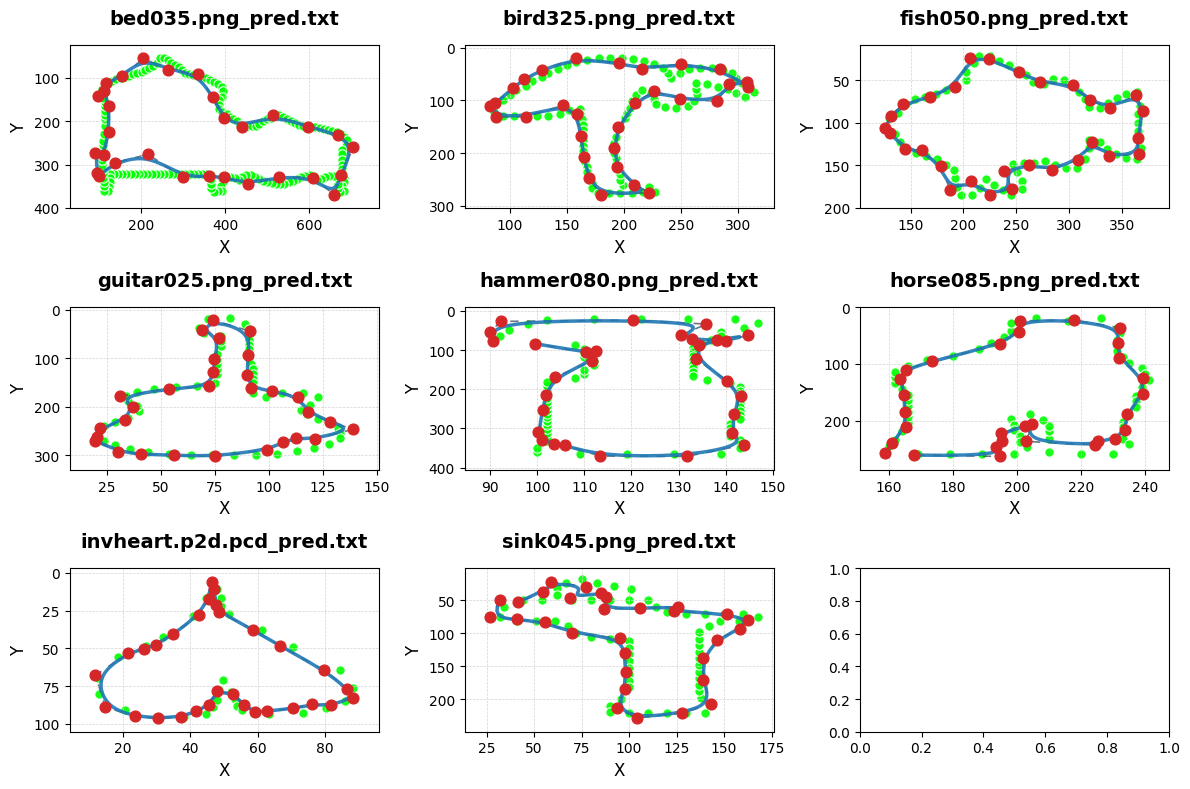

1

In [4]:
import torch
import time

# ================== 模型应用模块 ==================
def computeFitterError(model,pred_controls,data_points,u_params):
    '''
    计算B样条曲线与数据点直接的误差。
    返回绝对误差和相对误差
    '''
#     print('model:',model)
#     print('shape of pred_controls:',pred_controls.shape)
#     print('shape of data_points:',data_points.shape)
#     print('shape of u_params:',u_params.shape)
    
    curve_pts = evaluate_bspline(model, pred_controls, u_params)# 计算出预测出的控制顶点在uparams处的B样条曲线的值以便于数据点进行差值比较。注意，evaluatebspline函数中仅考虑准均匀B样条
    
#     print('shape of curve_pts:',curve_pts.shape)
    
    minr = np.min(data_points.numpy(),axis=0)
    maxr = np.max(data_points.numpy(),axis=0)
    diaglen = ((maxr[0] - minr[0]) ** 2 + (maxr[1] - minr[1]) ** 2) ** 0.5
    
    lossvec = curve_pts - data_points
    loss = (lossvec[:,0] ** 2 + lossvec[:,1] ** 2) ** (0.5)
#     print('shape of loss:',loss.shape)
    minloss = min(loss)
    maxloss = max(loss)
    
    aveloss =  np.sum(loss.numpy()) / len(loss) # 注意，这个是平均误差
    relaveloss = aveloss / diaglen
    relminloss = minloss / diaglen
    relmaxloss = maxloss / diaglen
    
    return aveloss,minloss,maxloss,relaveloss,relminloss,relmaxloss

def apply_trained_model(model_path, new_data_root, output_dir='./controls'):
    '''
    用已训练好模型，对newdataroot中的每个数据进行预测，预测出的控制顶点存储到outputdir中
    
    所有预测操作均应通过该函数完成，因其中涉及到控制顶点的 反规范化操作
    
    param model_path: 存储模型参数的路径。例如：saved_models/best_model.pth
    param new_data_root: 用于预测的数据集的路径文件夹。该文件夹中可以有多个数据文件，每个文件代表一个数据集
    param output_dir: 保存从newdataroot中的每个文件预测出来的控制顶点数据的文件夹。其中包含多个文件，每个文件代表一个数据集的控制顶点数据，文件命名方式和数据集文件命名方式有关联（添加_pred）
    '''
    # 加载模型配置
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    config = checkpoint['config']

    # 重建模型
    model = BSplineGNN(
        k=config['k'],
        hidden_dim=config['hidden_dim'],
        num_iter=5
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 加载新数据集
    new_dataset = PointCloudDataset(
        root=new_data_root,
        num_ctrl=config['num_ctrl']
    )
    new_loader = DataLoader(new_dataset, batch_size=1, shuffle=False)

    os.makedirs(output_dir, exist_ok=True)

    totaltime = 0
    with torch.no_grad():
        for batch in new_loader:
            starttime = time.perf_counter()
            pred_controls,_ = model(batch)
            endtime = time.perf_counter()
            totaltime += endtime - starttime
            
            
            aveloss,minloss,maxloss,relaveloss,relminloss,relmaxloss = computeFitterError(model,pred_controls=pred_controls,data_points=batch[0].x[pred_controls.shape[0]:,:],u_params=batch[0].u_params)
            print('*' * 66)
            print('AVE MSE loss:',aveloss)
            print('min loss:',minloss)
            print('max loss:',maxloss)
            print('accumulated loss:',aveloss * (batch[0].x.shape[0]-pred_controls.shape[0]))
            print('Relative AVE MSE:',relaveloss)
            print('Relative min loss:',relminloss)
            print('Relative max loss:',relmaxloss)
            print('Relative accumulated loss:',relaveloss * (batch[0].x.shape[0] - pred_controls.shape[0]))
            
            
            '''
            这里进行预测控制顶点的反规范化操作
            '''
            # 先读取原始数据文件，获取规范化过程中的参数
            filename = batch.filename[0]
            points = np.loadtxt(os.path.join(new_data_root, filename))
            print(f'当前数据点文件:{os.path.join(new_data_root, filename)}')
#             print('before normalization:',np.std(points,axis=0))
            points,mean,std = z_score_normalize(points) # 将数据规范化，重要的是要获取规范化过程中的参数
#             print('after normalization:',np.std(points,axis=0))
            
            # 随后将预测出来的控制顶点反规范化
            inv_normalized_pred_controls = inverse_z_score(pred_controls.cpu().numpy(),mean,std)

            # 保存预测结果
            filename = batch.filename[0].replace('.txt', '_pred.txt')
            save_path = os.path.join(output_dir, filename)
            np.savetxt(
                save_path,
#                 pred_controls.cpu().numpy(),
                inv_normalized_pred_controls,
                fmt='%.6f',
                header=f'Predicted Controls (Model: {os.path.basename(model_path)})'
            )
            
            print('&' * 66)
            
    print(f"数据集预测结果完成，控制顶点结果已保存至 {output_dir}")
    print(f'预测总时间:{totaltime}秒, 即{totaltime * 1000}毫秒')

# 执行预测
#应用模式
apply_trained_model(
    model_path='./saved_models/best_model.pth',
    new_data_root='./data/pred',
    output_dir='./controls'
)

import win32com.client as win
speak=win.Dispatch("SAPI.SpVoice")
speak.speak(f"预测结束了")



# 可视化部分
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ---------------------- B样条核心算法 ----------------------
def BaseFunction(i, k, u, knot):
    """B样条基函数计算 (优化版)"""
    lastNonDegradeKnot = -2
    for j in range(-2, -len(knot) - 1, -1):
        if knot[j] < knot[j + 1]:
            lastNonDegradeKnot = j
            break
    lastNonDegradeKnot += len(knot)

    if k == 1:
        if knot[i] >= knot[i + 1]:
            return 0.0
        condition = (u >= knot[i]) & (u <= knot[i + 1]) if i == lastNonDegradeKnot else (u >= knot[i]) & (
                u < knot[i + 1])
        return 1.0 if condition else 0.0
    else:
        denom1 = knot[i + k - 1] - knot[i]
        denom2 = knot[i + k] - knot[i + 1]
        term1 = 0.0 if denom1 == 0 else (u - knot[i]) / denom1 * BaseFunction(i, k - 1, u, knot)
        term2 = 0.0 if denom2 == 0 else (knot[i + k] - u) / denom2 * BaseFunction(i + 1, k - 1, u, knot)
        return term1 + term2

def generate_open_uniform_knots(n_ctrl, degree=3):
    """生成开放均匀节点向量"""
    total_knots = n_ctrl + degree + 1
    knots = np.zeros(total_knots)
    knots[-degree - 1:] = 1.0  # 尾部节点

    if n_ctrl > degree:
        internal = np.linspace(0, 1, n_ctrl - degree + 1)[1:-1]
        knots[degree + 1:-degree - 1] = internal
    return knots

def generate_bspline_curve(ctrl_points, degree=3, sample_num=200):
    """生成B样条曲线"""
    '''
    注意：这里并不要求ctrlpoints的范围必须是-1到+1之间，而是全支持。具体是先计算曲线点再变换，还是对控制顶点先变换在输入到本函数计算曲线，由用户决定。前置变换还是后置变换的问题。
    '''
    n = len(ctrl_points)
    if n < 2:
        return np.array([])

    actual_degree = min(degree, n - 1)
    knots = generate_open_uniform_knots(n, actual_degree)
    u_values = np.linspace(0, 1, sample_num)

    curve = []
    for u in u_values:
        point = np.zeros(2)
        for i in range(n):
            Nik = BaseFunction(i, actual_degree + 1, u, knots)
            point += ctrl_points[i] * Nik
        curve.append(point)
    return np.array(curve)

# ---------------------- 数据读取增强 ----------------------
def read_control_files(directory):
    """读取控制点文件（含异常处理）"""
    '''
    从directory中读取全部数据文件(其实是控制顶点数据)，返回一个字典：keys是每个数据文件的路径，values是每个数据文件的控制顶点数据
    '''
    file_pattern = os.path.join(directory, "*.txt")
    control_files = glob.glob(file_pattern)

    control_data = {}
    for file_path in control_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = [line.strip() for line in f if line.strip()]
                if not lines: continue

                # 解析控制点
                points = []
                for line in lines[1:]:  # 跳过标题行
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            x, y = map(float, parts[:2])
                            points.append((x, y))
                        except ValueError:
                            continue

                if len(points) >= 2:
                    control_data[os.path.basename(file_path)] = np.array(points)
        except Exception as e:
            print(f"Error reading {file_path}: {str(e)}")
    return control_data

def find_original_points(ctrl_filename, original_dir):
    """根据控制点文件名查找原始数据点"""
    '''
    给定控制顶点数据文件ctrlfilename，从起文件名推测对应的数据点文件名，将该文件载入并返回。
    这里并  未进行数据点的规范化， 也不必进行数据点的规范化。
    '''
    original_name = ctrl_filename.replace("_pred", "")
    original_path = os.path.join(original_dir, original_name)

    if os.path.exists(original_path):
        try:
            with open(original_path, 'r', encoding='utf-8') as f:
                lines = [line.strip() for line in f if line.strip()]
                points = []
                for line in lines[1:]:  # 跳过标题行
                    parts = line.split()
                    if len(parts) >= 2:
                        x, y = map(float, parts[:2])
                        points.append((x, y))
                return np.array(points) if len(points)>=2 else None
        except Exception as e:
            print(f"读取原始数据错误 {original_path}: {str(e)}")
    return None


# ---------------------- 可视化模块 ----------------------
def visualize_closed_paths(control_data, save_path=None, original_dir=None):
    """B样条拟合结果可视化"""
    '''
    从controldata中提取控制点数据（多组），用准均匀B样条曲线绘制，图片结果保存在savepath中。控制顶点对应的原始数据所在的路径存储在originaldir中。
    param control_data: 字典。keys是控制点文件对应的文件名，values是控制点数据
    '''
    fig=None
    axes=None
    if len(control_data) == 1:
        fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(12,8),dpi=100)
    elif len(control_data) == 2:
        fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,8),dpi=100)
    elif len(control_data) < 5:
        fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(12,8),dpi=100)
    elif len(control_data) < 9:
        fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(12,8),dpi=100)
    else:
        raise ValueError('可视化最多支持9个数据')
        return
#     plt.figure(figsize=(12, 8), dpi=100)
#     ax = plt.gca()

    # 严格配色方案
    input_point_color = '#00ff00'   # 输入点灰色
    curve_color = '#1f77b4'         # 曲线蓝色
    control_point_color = '#d62728' # 控制点红色
    polygon_color = '#2C3E50'        # 控制多边形深灰

    # 收集所有数据点
#     all_points = [] # 目的是当有多个数据文件的时候，显示在一个窗口中。这其实是没必要的。正确的做法应该是开辟多个窗口，每个窗口显示一个数据。

    for idx, (filename, ctrl_points) in enumerate(control_data.items()):
        '''
        从controldata中推测数据点文件名并载入
        '''
        if len(control_data) == 1:
            ax = axes
        elif len(control_data) == 2:
            ax = axes[idx]
        elif len(control_data) < 5:
            ax = axes[idx//2][idx - idx//2*2]
        elif len(control_data) < 9:
            ax = axes[idx//3][idx - idx//3*3]
        else:
            pass
        
        # ================= 原始数据点 =================
        if original_dir:
            original_points = find_original_points(filename, original_dir) # 推测数据点文件名并载入数据。该数据   无需进行规范化
            if original_points is None:
                print(f'{filename} 数据点未找到')
            if original_points is not None:# 显示原始数据点
                ax.scatter(original_points[:, 0], original_points[:, 1],
                          s=45,                # 增大点尺寸
                          marker='o',
                          edgecolor='white',  # 添加白色边框
                          linewidths=0.8,      # 边框粗细
                          facecolor= input_point_color, # 使用更深灰色
                          alpha=0.9,          # 提高不透明度
                          zorder=0,
                          label='Input Points')

                
        # ================= 控制多边形（恢复显示） =================
        ax.plot(ctrl_points[:, 0], ctrl_points[:, 1],
               linestyle=(0, (5, 5)),  # 虚线样式
               linewidth=1.2,
               color=polygon_color,
               alpha=0.7,
               zorder=1,
               label='Control Polygon')

        # ================= 控制点（改为实心红点） =================
        ax.scatter(ctrl_points[:, 0], ctrl_points[:, 1],
                  s=60, marker='o',
                  edgecolor=control_point_color,
                  linewidths=1.0,
                  facecolor=control_point_color,  # 实心填充
                  zorder=3,
                  label='Control Points')

        
        # ================= B样条曲线 =================
        curve = generate_bspline_curve(ctrl_points)
        if curve.size > 0:
            ax.plot(curve[:, 0], curve[:, 1],
                   linewidth=2.5,
                   color=curve_color,
                   alpha=0.9,
                   solid_capstyle='round',
                   zorder=2,
                   label='B-spline Curve')
            
            

#         all_points.append(ctrl_points)

    # ================= 自适应坐标范围 =================
#     combined_points = np.vstack(all_points)
        combined_points = ctrl_points
        x_pad = np.ptp(combined_points[:, 0]) * 0.1
        y_pad = np.ptp(combined_points[:, 1]) * 0.1

        # ax.set_aspect('equal', adjustable='datalim')  # 保证XY轴单位长度一致

        ax.set_xlim(combined_points[:, 0].min()-x_pad,
                   combined_points[:, 0].max()+x_pad)
        ax.set_ylim(combined_points[:, 1].min()-y_pad,
                   combined_points[:, 1].max()+y_pad)
        ax.invert_yaxis()

        # ================= 画布样式 =================
        ax.set_facecolor('white')
        ax.grid(True, linestyle='--', color='#D3D3D3', linewidth=0.5)
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)
        ax.set_title(filename,
                    fontsize=14, pad=15, weight='bold')

        # ================= 图例优化 =================
        handles, labels = ax.get_legend_handles_labels()
        legend_order = {
            'Input Points': 0,
            'B-spline Curve': 1,
            'Control Points': 2,
            'Control Polygon': 3
        }
        sorted_handles = [h for _, h in sorted(zip(labels, handles),
                              key=lambda x: legend_order.get(x[0], 4))]
        sorted_labels = sorted(labels, key=lambda x: legend_order.get(x, 4))
        
#         ax.legend(sorted_handles, sorted_labels,
#                  loc='upper right',
#                  frameon=True,
#                  edgecolor='black',
#                  fontsize=10)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# ---------------------- 主程序（保持原有结构）---------------------

# 控制点目录
CTRL_DIR = "./controls" # 存储的是在main中用mode=1获得的对于已保存到savedmodel中的bestmodel作用到数据文件夹pred中每个数据预测出来并保存到controls中的控制顶点

# 原始数据目录（根据实际情况修改）
ORIGINAL_DIR = "data/pred" # 对应与controls中的控制顶点数据的原始数据点数据文件

control_data = read_control_files(CTRL_DIR) # 从控制顶点文件夹中读取全部文件名和响应的数据
if control_data:
    print(f"成功加载 {len(control_data)} 个控制点文件")
    visualize_closed_paths(
        control_data,
        save_path="./enhanced_visualization.png",
        original_dir=ORIGINAL_DIR
    )
else:
    print(f"目录 {CTRL_DIR} 中未找到有效控制点文件")

import win32com.client as win
speak=win.Dispatch("SAPI.SpVoice")
speak.speak('可视化结束了')

# 与其他算法的效果对比 

##  LSPIA方法

******************************
LSPIA方法处理文件./data/pred/bed035.png.txt中......
number of data points: 171
init number of control points: 30
parameters of original data(171): [0.         0.0069222  0.013319   0.01899108 0.02466316 0.0301952
 0.03526579 0.04079783 0.04586843 0.05140047 0.05647106 0.06154165
 0.06721373 0.07288581 0.07855788 0.08486867 0.09265232 0.0975368
 0.10320887 0.10942112 0.11529555 0.12082759 0.12670202 0.13309882
 0.13816942 0.14324001 0.1483106  0.15384264 0.15891324 0.16444528
 0.16997732 0.1756494  0.18152382 0.18848432 0.19638839 0.2027852
 0.2097074  0.2166296  0.22309593 0.22862798 0.2345024  0.24037683
 0.24604891 0.25244571 0.25811778 0.26318838 0.26807285 0.27295733
 0.27883176 0.28470619 0.29023823 0.29577027 0.30144235 0.30637535
 0.31204743 0.3177195  0.32325155 0.32878359 0.33465802 0.33972861
 0.34461309 0.34968368 0.35456816 0.35963875 0.36470934 0.36977993
 0.37485053 0.38038257 0.38591461 0.39178904 0.39818584 0.40638664
 0.41293052 0.41985272 0.428

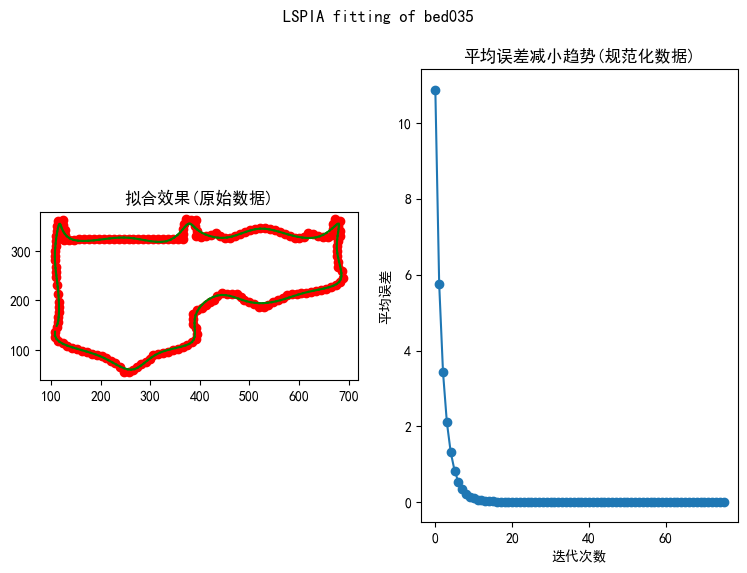

******************************
LSPIA方法处理文件./data/pred/bird325.png.txt中......
number of data points: 95
init number of control points: 30
parameters of original data(95): [0.         0.01102755 0.02200914 0.03329841 0.04464605 0.05595
 0.06725395 0.07877153 0.08953922 0.1009586  0.1105505  0.12018808
 0.12982567 0.13941757 0.14900947 0.15860137 0.16819327 0.17778517
 0.18742275 0.19706034 0.20683122 0.21642312 0.226194   0.23596489
 0.24555679 0.25577861 0.26706788 0.27835715 0.28964641 0.30099406
 0.31228333 0.32250515 0.33541641 0.34676406 0.35653494 0.36612684
 0.37589772 0.38566861 0.3952605  0.40503139 0.41462329 0.42421519
 0.43398607 0.44714954 0.46031302 0.4700839  0.47985478 0.49049948
 0.50152703 0.51174885 0.52251654 0.53228742 0.5420583  0.55282599
 0.56417364 0.57569122 0.58591304 0.59750447 0.60714205 0.61673395
 0.6280379  0.63915473 0.65027155 0.66102594 0.67200753 0.68372643
 0.69402868 0.7042505  0.71447232 0.72445395 0.73522163 0.74673921
 0.75802848 0.76944786 0.7806

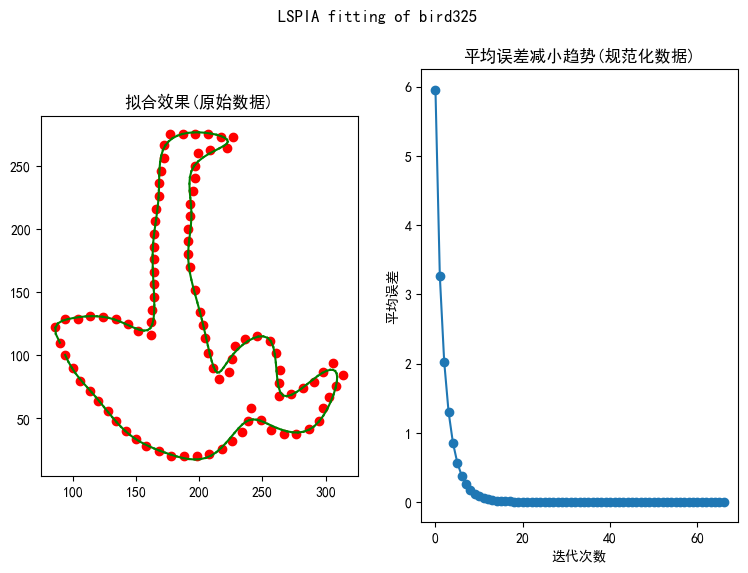

******************************
LSPIA方法处理文件./data/pred/fish050.png.txt中......
number of data points: 72
init number of control points: 30
parameters of original data(72): [0.         0.01505847 0.02852879 0.04454683 0.05801715 0.07053797
 0.08377993 0.09705929 0.10989544 0.12493416 0.13999263 0.15601067
 0.17075647 0.18307602 0.19635538 0.20963474 0.22310506 0.23657538
 0.25105385 0.26357468 0.27685404 0.28917359 0.30264391 0.31687496
 0.33110602 0.34642164 0.3587412  0.37221151 0.38568183 0.39896119
 0.41148201 0.43060254 0.44572654 0.46078501 0.47584348 0.49091842
 0.50604241 0.52338699 0.53590782 0.54914978 0.5626201  0.57709857
 0.58993473 0.6049932  0.62168605 0.638324   0.65057423 0.66381619
 0.67705815 0.68957897 0.7018292  0.71414875 0.72946438 0.74478
 0.75983847 0.77461816 0.78808848 0.80155879 0.81566619 0.83180542
 0.84655446 0.85880469 0.87412031 0.88924431 0.90431924 0.91778956
 0.93125987 0.94450183 0.95774379 0.97102315 0.9852542  1.        ]
init knot vector(34): [0.   

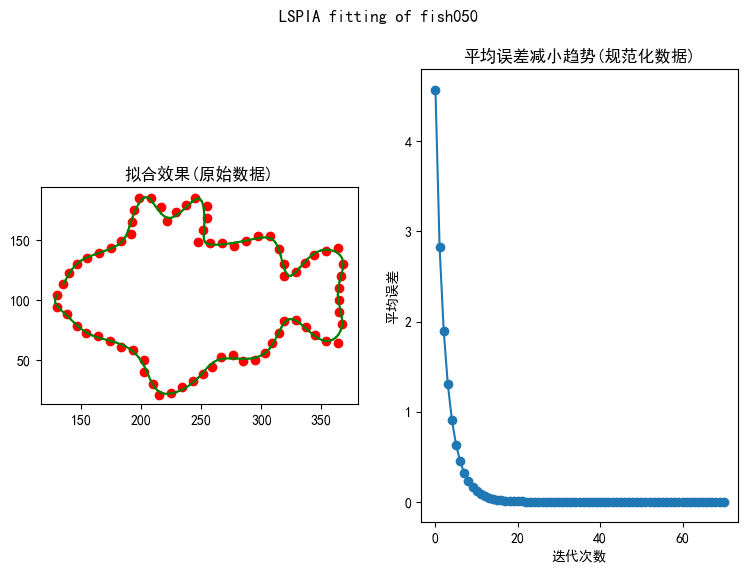

******************************
LSPIA方法处理文件./data/pred/guitar025.png.txt中......
number of data points: 66
init number of control points: 30
parameters of original data(66): [0.         0.01211757 0.02504733 0.04052512 0.05686542 0.07411025
 0.08644623 0.10117904 0.11351502 0.12899281 0.14720324 0.1672544
 0.18730557 0.205516   0.22230394 0.23442151 0.24653908 0.25865665
 0.27077422 0.28739121 0.29950877 0.31162634 0.32983678 0.34276654
 0.36034162 0.38035927 0.39854191 0.41147167 0.4247458  0.43686337
 0.44898094 0.46109851 0.47321608 0.48533365 0.49766963 0.51000561
 0.52212318 0.53424075 0.54635832 0.55847589 0.57059345 0.58693376
 0.60435222 0.62434293 0.6417614  0.65861849 0.67335129 0.68711946
 0.70259725 0.71807503 0.73280784 0.74514382 0.75726139 0.77388484
 0.7913033  0.80962868 0.82878808 0.84880573 0.86879644 0.88878715
 0.90877787 0.92879551 0.94889332 0.96710375 0.98452221 1.        ]
init knot vector(34): [0.         0.         0.         0.         0.01786413 0.05504983
 0

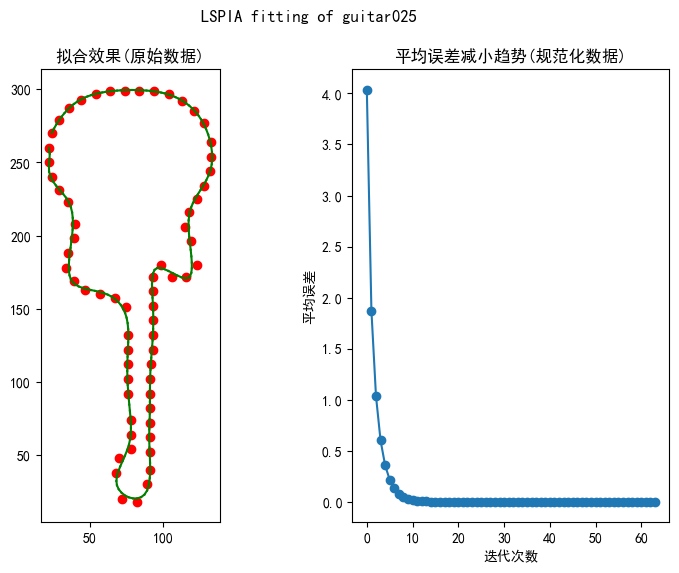

******************************
LSPIA方法处理文件./data/pred/hammer080.png.txt中......
number of data points: 73
init number of control points: 30
parameters of original data(73): [0.         0.0106299  0.02500123 0.04292517 0.05991366 0.08571018
 0.1114769  0.13724362 0.1630178  0.18165082 0.19759934 0.21623236
 0.22686227 0.24006662 0.25327097 0.26704713 0.27767703 0.28830694
 0.29893684 0.30956674 0.32019664 0.33082655 0.34145645 0.35658908
 0.3752221  0.38842645 0.39905636 0.40968626 0.42031616 0.43094607
 0.44157597 0.45220587 0.46283577 0.47346568 0.4881392  0.4987691
 0.50939901 0.52002891 0.53323326 0.54386316 0.55449307 0.57224264
 0.59800936 0.62377608 0.6495428  0.6740417  0.68467161 0.7002568
 0.7108867  0.72151661 0.73214651 0.74277641 0.75340631 0.76403622
 0.77466612 0.78529602 0.79592592 0.80655583 0.81718573 0.82781563
 0.83844553 0.84907544 0.85970534 0.88005405 0.8932584  0.9038883
 0.91856183 0.92919173 0.94239608 0.95302599 0.96365589 0.97686024
 1.        ]
init knot vect

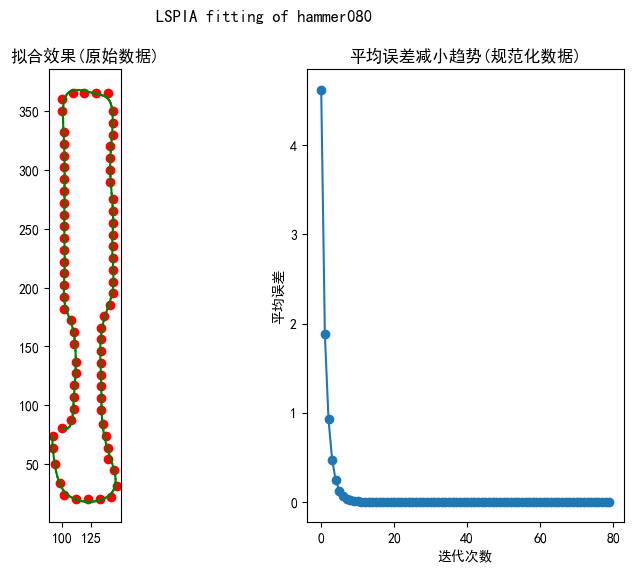

******************************
LSPIA方法处理文件./data/pred/horse085.png.txt中......
number of data points: 63
init number of control points: 30
parameters of original data(63): [0.         0.01347776 0.02784562 0.04535966 0.06186925 0.07534701
 0.08882476 0.10230252 0.11578028 0.12925804 0.1436259  0.15799376
 0.17147152 0.18494928 0.20129991 0.21989518 0.2403489  0.2615337
 0.27788433 0.29500864 0.3093765  0.3253236  0.34577731 0.36804239
 0.39030747 0.40980746 0.42352434 0.43847184 0.4519496  0.46542735
 0.47979522 0.49416308 0.51051371 0.52423058 0.53794746 0.55340797
 0.57092202 0.58439977 0.59787753 0.61438712 0.62984763 0.64332539
 0.65680315 0.6702809  0.68464877 0.70450595 0.72665048 0.74891556
 0.76935559 0.7847226  0.79820036 0.81256822 0.82891885 0.84703399
 0.86075087 0.87422863 0.88859649 0.90207425 0.91644211 0.93356642
 0.95571095 0.97785547 1.        ]
init knot vector(34): [0.         0.         0.         0.         0.01826705 0.05636605
 0.08882476 0.12027286 0.15320447 0.

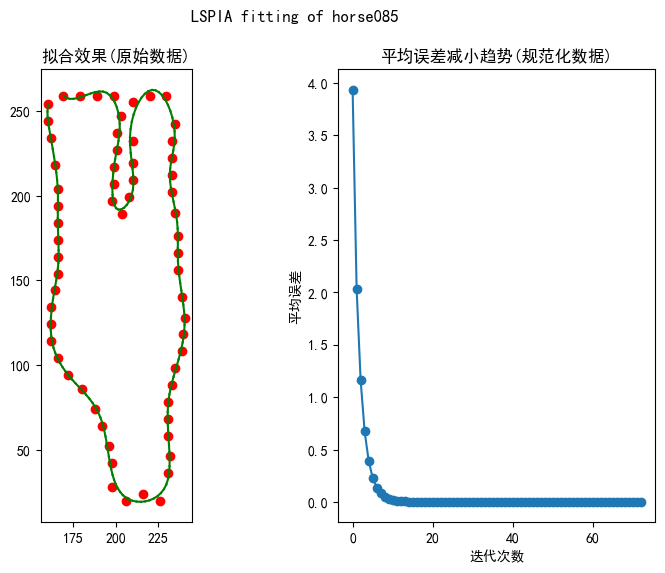

******************************
LSPIA方法处理文件./data/pred/invheart.p2d.pcd.txt中......
number of data points: 34
init number of control points: 30
parameters of original data(34): [0.         0.03383205 0.06891742 0.11121547 0.1412259  0.16967179
 0.19251636 0.23148953 0.26330156 0.30119718 0.33934411 0.37142853
 0.4018432  0.4246801  0.44664743 0.47210058 0.49749892 0.5263656
 0.54783659 0.56804455 0.58676162 0.609637   0.63479448 0.67166573
 0.70328381 0.73310437 0.76256855 0.79785853 0.84695523 0.88745055
 0.92853666 0.95269668 0.97570123 1.        ]
init knot vector(34): [0.         0.         0.         0.         0.00877127 0.05202446
 0.1018159  0.14227945 0.17644055 0.21416812 0.25741044 0.30402288
 0.35003892 0.38945204 0.42129685 0.44947555 0.48150737 0.51567424
 0.54545092 0.57081745 0.59608122 0.62640865 0.66893453 0.70880614
 0.74619956 0.78740224 0.84513683 0.8965808  0.94016926 0.96973709
 1.         1.         1.         1.        ]
Finish iterating 116 times. 误差值(全部数据点误差之和)

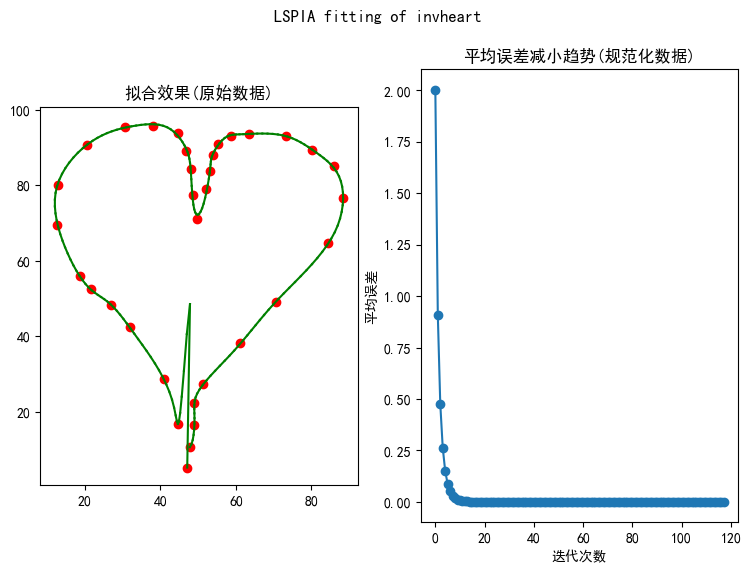

******************************
LSPIA方法处理文件./data/pred/sink045.png.txt中......
number of data points: 62
init number of control points: 30
parameters of original data(62): [0.         0.01352652 0.03084537 0.04838909 0.06645906 0.08452903
 0.10100381 0.11599719 0.1330538  0.1512501  0.1694464  0.18297292
 0.19649945 0.21002597 0.2235525  0.23707902 0.25060555 0.26413207
 0.28295476 0.29932748 0.312854   0.33093814 0.34900811 0.36707808
 0.38514805 0.40321802 0.4189234  0.43391678 0.44754975 0.46107627
 0.47460279 0.48812932 0.50165584 0.51518237 0.52870889 0.54223542
 0.55576194 0.56928847 0.58451624 0.60015453 0.6182245  0.6366391
 0.65347209 0.67154206 0.68961203 0.707682   0.72580845 0.74144673
 0.75644012 0.77451009 0.79258006 0.81065003 0.82873417 0.8539842
 0.87152791 0.88907162 0.91903858 0.93587157 0.95109935 0.96462587
 0.98193003 1.        ]
init knot vector(34): [0.         0.         0.         0.         0.01865804 0.05909722
 0.09917328 0.13642349 0.17595917 0.20702008 0.23

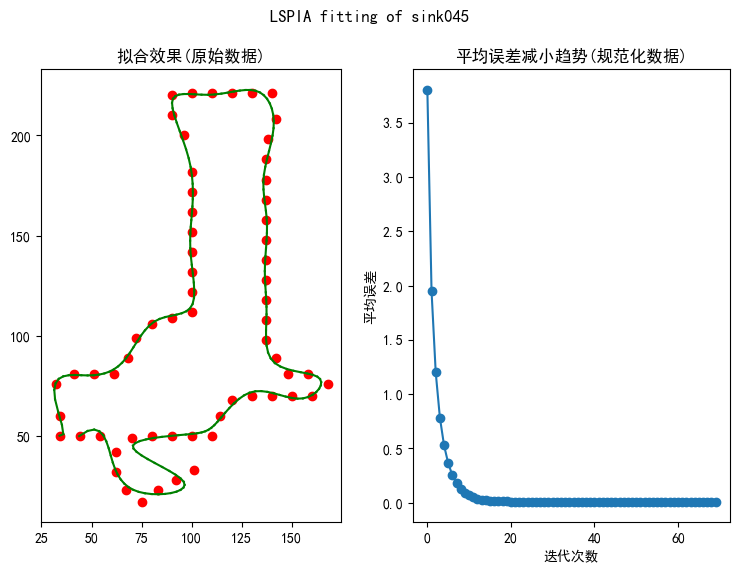

LSPIA 总用时11.444768300000533 秒, 即11444.768300000533 毫秒


In [10]:
import sys,os
sys.path.append('E:/_Papers/_code/curve_fitting/_MyExperiments')
from LSPIA_master import LSPIA
import time


datafolder = './data/pred/'

nCtlPts = 30
totaltime = 0

# 数据规范化和反规范化应该是外部做，不应在拟合函数内部做。
# 有些不公平：lspia中的数据读取、数据规范化、数据可视化的时间都被算进去了
# 将来可以在LSPIA函数内部精确记录工作时间，然后返回来，并返回迭代了多少次这样的参数
filelist = os.listdir(datafolder)
for file in filelist:
    if not file[-3:] == 'txt':
        continue
    file = datafolder + file
    starttime = time.perf_counter()
    data_parameters,knot_vector,ctlPts = LSPIA.LSPIA_curve(file=file,degree=3,nCtlPts=nCtlPts,vis=True,normdata=True)
    endtime = time.perf_counter()
    totaltime += endtime - starttime

print(f'LSPIA 总用时{totaltime} 秒, 即{totaltime * 1000} 毫秒')
